## Shooting Style Analysis

Our interest during this part of this project is in whether there is a substantial difference in play style for players between the playoff and regular season. This question stems from the relationship between the regular season and playoff season, as the regular season games outcomes do not matter nearly as much as playoff games.

We will analyze shot selection in this notebook to determine what changes in shooting patterns players take between regular and playoff seasons.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import myFunctions as mf
import importlib
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from dateutil import parser
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from dateutil import parser
import datetime

In [3]:
# Load the pickle titled allplayers.p into a pandas dataframe called plyrs
plyrs = pickle.load(open( "allplayers.p", "rb" ))
# Load the pickle titled allplyrs.p into a pandas dataframe called plyrs
plyrsreg = pickle.load(open("allplayersregular.p","rb"))
PIDS = [i for i in plyrs.keys()]

## Regular Season vs Playoffs Shot Selection

Here we are creating the dataframe we will use for this analysis.

We filter out players who took fewer than 15 shots during the playoff season, and 50 shots during the regular season. 

The players' regular season and playoff season shot records are separated by negating the player id for playoff games

In [4]:
# Create DataFrames with all shot data from Regular season and Playoffs
shots =  []
for i in PIDS:
    # Skip players who did not take over 50 shots during regular season and 15 during 
    if(len(plyrsreg[i].index) < 50 or len(plyrs[i].index) < 15):
        continue 
    shots.append(plyrsreg[i])
    tmp = plyrs[i]
    # To distinguish playoffs season statistics from regular season statistics without need to 2 graphs:
    tmp['PLAYER_ID'] *= -1
    shots.append(tmp)
allshots = pd.concat(shots,ignore_index = True)

### Non-negative Matrix Factorization

Here we create binned histograms of players shot selections using the shots of players who fit our criteria above. We will use these bins to compute NMF on all of the players

In [5]:
# Creating smoothed bins of shots for all players
xedges = np.linspace(start=-300, stop=300, num=151)
yedges = np.linspace(start=-48, stop=372, num=106)
bin_edges = (xedges, yedges)

nx = xedges.size - 1
ny = yedges.size - 1
player_dict = {}
FPIDS = []
all_smooth = []

for i in enumerate(allshots.groupby('PLAYER_ID')):
    tmp, xedges, yedges = mf.bin_shots(i[1][1], bin_edges=(xedges, yedges), density=True, sigma=2) ## so? #i[1][1] is df
    ## what is this refering to? # vectorize and store into list
    all_smooth += [tmp.reshape(-1)]
    FPIDS.append(i[1][1].PLAYER_ID.iloc[0])
    ## what is this?? #FPIDS.append(-i[1][1].PLAYER_ID.iloc[0])
    player_dict[i[1][1].PLAYER_ID.iloc[0]] = i[1][1].PLAYER_NAME.iloc[0]

X = np.vstack(all_smooth).T
p,n = X.shape
## why are you printing this? also what is p and what is n? why is shit out of order?
print("Number of Players: ", n) ## ?
print("Number of Shot Regions: ", p) ## ?
## print(p,n) # n is number of players, p is shot regions

15750 22


Compute the NMF on all player's shot charts, X, assuming n_components = 7 (i.e. represent each shot chart as a positive linear combination of 7 "basis" shot charts). ??

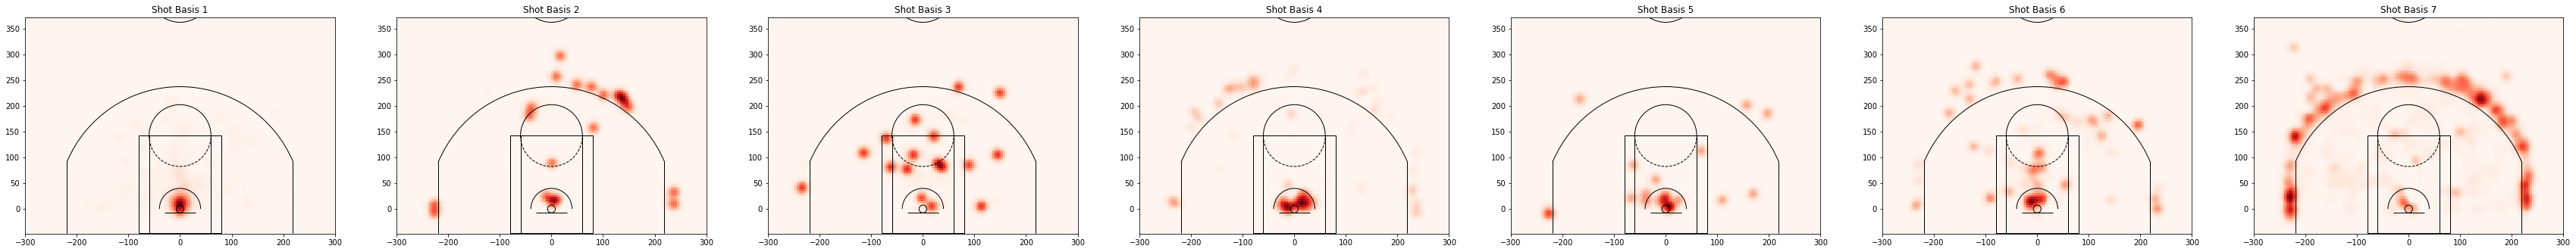

In [6]:
W,H = mf.non_negative_marix_decomp(7,X)
fig, ax = plt.subplots(1, 7, figsize=(60,20))
for i in range(7):
    mf.plot_vectorized_shotchart(W[:,i],xedges,yedges,ax = ax[i])
    ax[i].set_title('Shot Basis %i' % (i+1))

We see there is a nice variety within the bases. Lets see what kind of insight the coefficients can provide

In [7]:
comp = []
for i in range(len(FPIDS)):
    comp.append([H[:,i].round(3)])
comp = pd.DataFrame(index = FPIDS, data = comp)

indices = []
rows = []
for i in FPIDS:
    if(i < 0):
        continue
    ## why is a bunch of stuff commented out?
    #print("Player Name:",player_dict[i])
    #print("Shots Taken Regular Season:",len(plyrsreg[i].index))
    #print("Shots Taken Playoffs:",len(plyrs[i].index))
    #print(comp.loc[i][0])
    #print(comp.loc[-i][0])
    indices.append(player_dict[i])
    rows.append(comp.loc[-i][0] - comp.loc[i][0])
    
compare = pd.DataFrame(data = rows,index = indices, columns = ["SHOTBASIS" + str(i) for i in range(1,8)])

what are you trying to show with the plot below? why plot it? purpose?

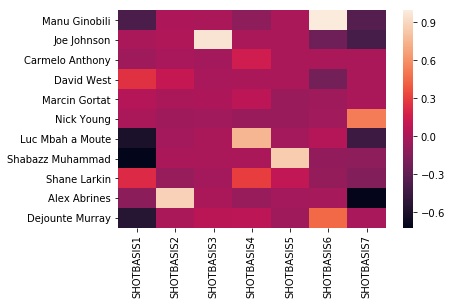

In [8]:
sns.heatmap(compare)
plt.show()

### Analysis

Above is a plot of the difference between a players NMF coefficient for playoffs and regular season. 

...i hope this isnt the analysis

## Individual Shot Selection between Different Quarters

is this a second part of the project? maybe place in a different file then?

In [9]:
# Create DataFrame using All Shot Data from Regular Season
shots =  []
tmp = []
flag = True
for i in PIDS:
    # what is this for loop doing?
    for j in range(4):
        # what do these numbers represent?
        if(len(plyrsreg[i].PERIOD.value_counts()) < 4  or plyrsreg[i].PERIOD.value_counts().iloc[j] < 2):
            flag = False
    # what is this if statement doing?
    if flag:
        temp = plyrsreg[i].copy()
        temp.drop(temp.index[temp.PERIOD>4],inplace = True) # Remove data that goes into overtime
        shots.append(temp)
    flag = True
    
periodShots = pd.concat(shots,ignore_index = True)

In [18]:
## parameters we'll use for our query?? what is all of this stuff being defined
player_dict = {}
FPIDS = []
FPIDSloop = []
player_name = []
period = []
numShots = {}
all_smooth = []

for i in enumerate(periodShots.groupby(['PLAYER_ID','PERIOD'])):
    temp = i[1][1]
    ## why is this commented out? #temp.drop([temp.PERIOD > 4])
    tmp, xedges, yedges = mf.bin_shots(temp, bin_edges=(xedges, yedges), density=True, sigma=2) ## again, wut? #i[1][1] is df 
    ## again, wut? # vectorize and store into list
    all_smooth += [tmp.reshape(-1)]
    if(temp.PLAYER_ID.iloc[0] not in FPIDS):
        FPIDS.append(temp.PLAYER_ID.iloc[0])
        player_dict[temp.PLAYER_ID.iloc[0]] = temp.PLAYER_NAME.iloc[0]
        numShots[temp.PLAYER_ID.iloc[0]] = []
    player_name.append(temp.PLAYER_NAME.iloc[0])
    FPIDSloop.append(temp.PLAYER_ID.iloc[0])
    period.append(temp.PERIOD.iloc[0])
    numShots[temp.PLAYER_ID.iloc[0]].append(len(i[1][1]))
    
X = np.vstack(all_smooth).T
p,n = X.shape
## why are you printing this? also what is p and what is n? why is shit out of order?
print("Number of Players: ", n) ## ?
print("Number of Shot Regions: ", p) ## ?
## print(p,n) # n is number of players, p is shot regions

Number of Players:  400
Number of Shot Regions:  15750
15750 400


### Non-negative Matrix Factorization

again, why do this? whaat do you hope to learn?
How? what are the steps
        Create Smoothed Bins of Shots for All Players

In [11]:
n = 7
W,H = mf.non_negative_marix_decomp(n,X)

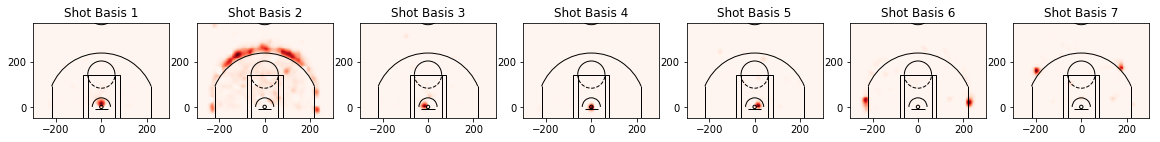

In [12]:
# what are you doing?
fig, ax = plt.subplots(1, n, figsize=(20,60))
for i in range(n):
    mf.plot_vectorized_shotchart(W[:,i],xedges,yedges,ax = ax[i])
    ax[i].set_title('Shot Basis %i' % (i+1))


The set of bases above represent a very basic but well encompasing set of standard shot styles. While there definitly appears to be an over representation of close shots, the bases above still provide valuable information given each of the close shot bases denotes a different types of close shot. The bases representing close shots are 1, 3, 4, and 5. Basis 1 depicts shots from the center while 3 and 5 illustrate left side layups and right side layups respectively. Then the last close shot basis, 4, represents a dunk.

In [13]:
## what is this doing?
comprounded = []
for i in range(len(FPIDSloop)):
    comprounded.append([H[:,i].round(3)][0])
comprounded = pd.DataFrame(index = [player_name,period], data = comprounded, columns = ["SHOTBASIS" + str(i) for i in range(1,8)])

again, explain what you are doing below and why.

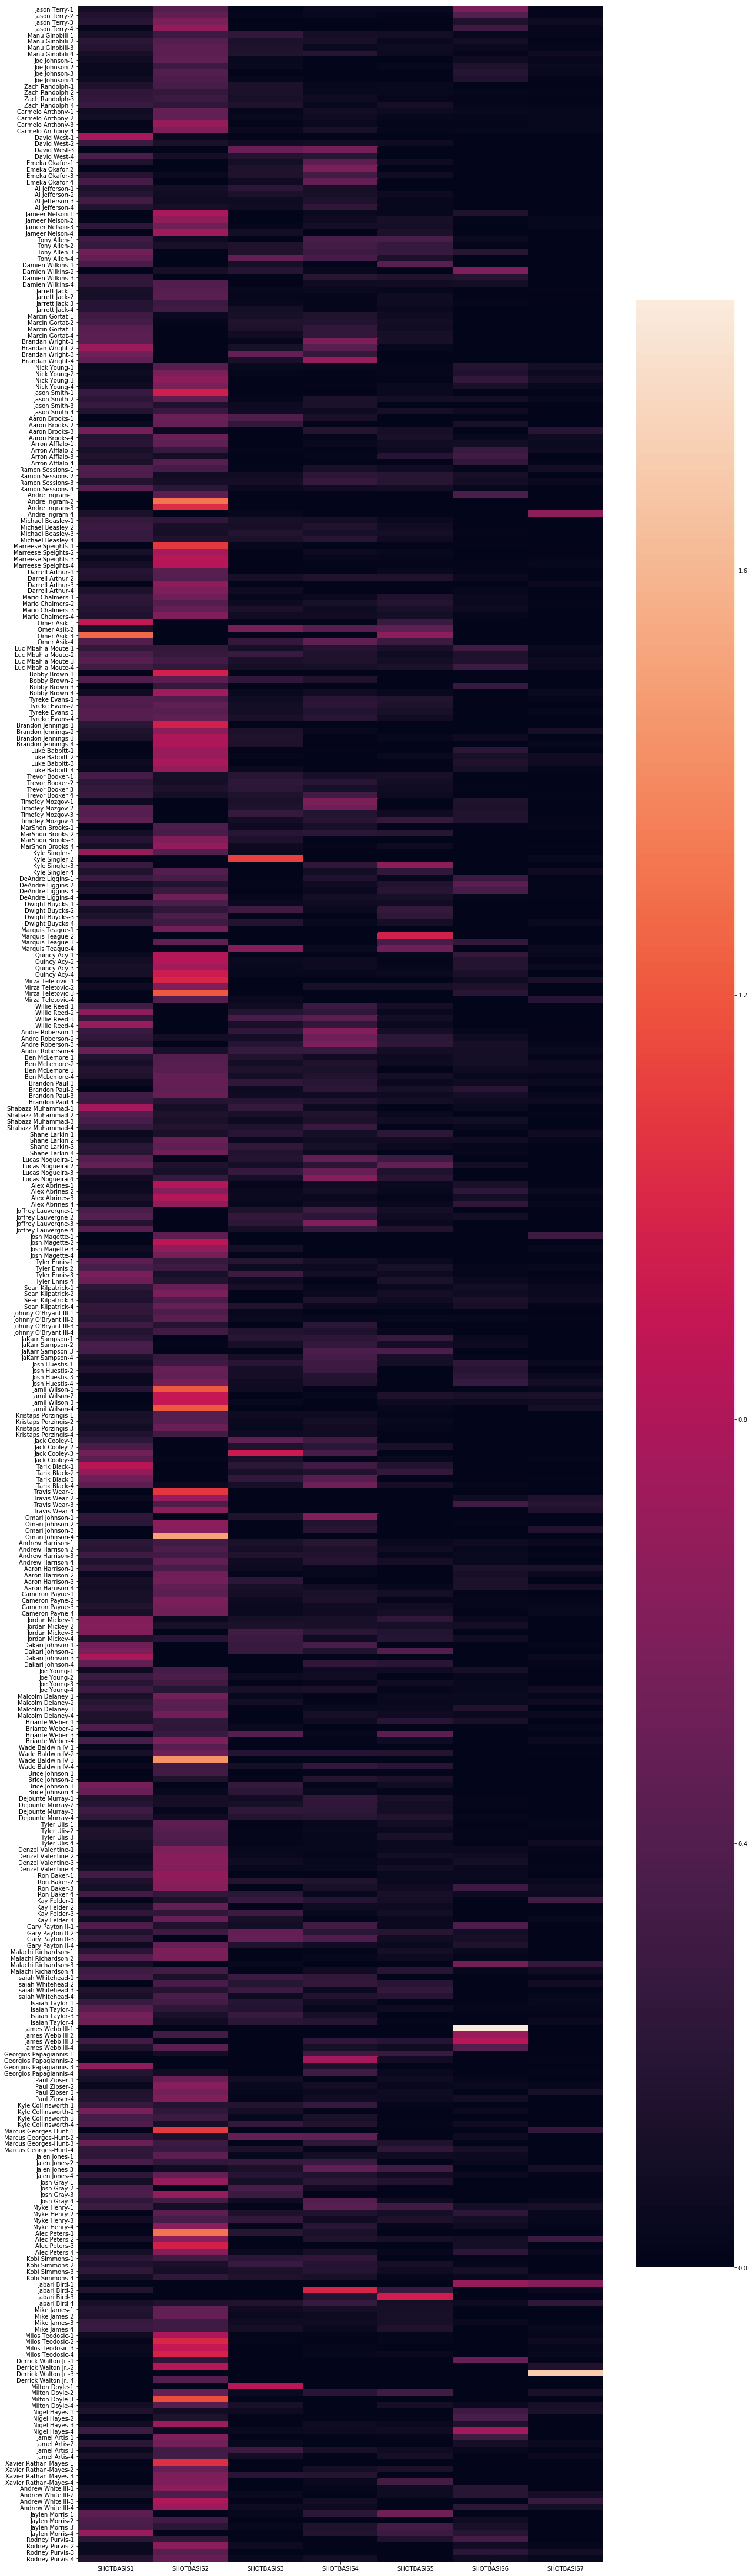

In [25]:
plt.figure(figsize = (20,80))
sns.heatmap(comprounded)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.show()
## why four outputs for each person?

what are you trying to show with the graph above?

interactive(children=(Dropdown(description='Player:', options=('Aaron Brooks', 'Aaron Harrison', 'Al Jefferson…

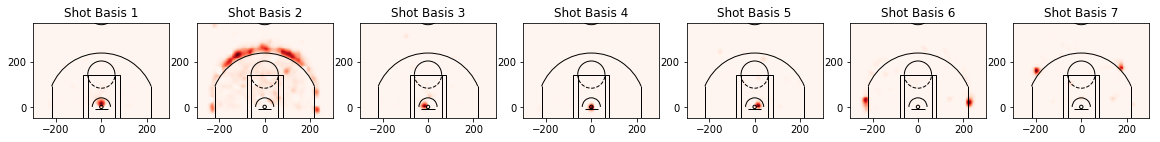

In [15]:
# purpose of function?
def plotHeat(df,player):
    sns.heatmap(df.loc[player])
    plt.title(player + "'s Shot Selection By Period")
    plt.show()
    
interact(plotHeat,df = fixed(comprounded), player = widgets.Dropdown(options=comprounded.index.levels[0].values,
                                                                     description='Player:',
                                                                     disabled=False, ))
fig, ax = plt.subplots(1, n, figsize=(20,60))
for i in range(n):
    mf.plot_vectorized_shotchart(W[:,i],xedges,yedges,ax = ax[i])
    ax[i].set_title('Shot Basis %i' % (i+1))
plt.show()

One common trend we notice is that many players have a big increase in the bases corresponding to 3 point shots toward the end of the game.

INCLUDE MORE

## Period Analysis

### Comparing Bases for All Players between Periods

The heatmap of period coefficients is large and difficult to analyze; however, we can simply compare the bases of NMF between each of the periods for all shooters ... to do what? why does this solve our problem?



In [ ]:
# Redoing this so we can include overtime
## define "this"
shots =  []
tmp = []
for i in PIDS:
    temp = plyrsreg[i].copy()
    shots.append(temp)
periodShots = pd.concat(shots,ignore_index = True)

In [ ]:
# what are all these things you have defined
per1 = []
per2 = []
per3 = []
per4 = []
per5 = []

for i in enumerate(periodShots.groupby(['PLAYER_ID','PERIOD'])):
    temp = i[1][1]
    ## wut?
    if len(temp) < 2 :
        continue
    tmp, xedges, yedges = mf.bin_shots(temp, bin_edges=(xedges, yedges), density=True, sigma=2) ## wut? #i[1][1] is df
    ## wut? # vectorize and store into list
    ## WUUUUUT?
    if temp.PERIOD.iloc[0] == 1:
        per1 += [tmp.reshape(-1)]
    if temp.PERIOD.iloc[0] == 2:
        per2 += [tmp.reshape(-1)]
    if temp.PERIOD.iloc[0] == 3:
        per3 += [tmp.reshape(-1)]
    if temp.PERIOD.iloc[0] == 4:
        per4 += [tmp.reshape(-1)]
    if temp.PERIOD.iloc[0] == 5:
        per5 += [tmp.reshape(-1)]

X1 = np.vstack(per1).T
X2 = np.vstack(per2).T
X3 = np.vstack(per3).T
X4 = np.vstack(per4).T
X5 = np.vstack(per5).T

##what is this!?
print(X1.shape) ## why is this comment here??? # n is number of players, p is shot regions 
print(X2.shape)
print(X3.shape)
print(X4.shape)
print(X5.shape)

what is thiiiiiiiiiiis? explain yourself

In [ ]:
n = 7
W1,H1 = mf.non_negative_marix_decomp(n,X1)
W2,H2 = mf.non_negative_marix_decomp(n,X2)
W3,H3 = mf.non_negative_marix_decomp(n,X3)
W4,H4 = mf.non_negative_marix_decomp(n,X4)
W5,H5 = mf.non_negative_marix_decomp(n,X5)

waaaaaaaaaat

In [ ]:
fig, ax = plt.subplots(5, n, figsize=(20,15))
for i in range(n):
    mf.plot_vectorized_shotchart(W1[:,i],xedges,yedges,ax = ax[0,i])
    ax[0,i].set_title('Period 1 Shot Basis %i' % (i+1))
for i in range(n):
    mf.plot_vectorized_shotchart(W2[:,i],xedges,yedges,ax = ax[1,i])
    ax[1,i].set_title('Period 2 Shot Basis %i' % (i+1))
for i in range(n):
    mf.plot_vectorized_shotchart(W3[:,i],xedges,yedges,ax = ax[2,i])
    ax[2,i].set_title('Period 3 Shot Basis %i' % (i+1))
for i in range(n):
    mf.plot_vectorized_shotchart(W4[:,i],xedges,yedges,ax = ax[3,i])
    ax[3,i].set_title('Period 4 Shot Basis %i' % (i+1))
for i in range(n):
    mf.plot_vectorized_shotchart(W5[:,i],xedges,yedges,ax = ax[4,i])
    ax[4,i].set_title('Period 5 Shot Basis %i' % (i+1))

## General Period Analysis

Period 1:
From the Period Shot Basis analysis, we notice that the most common three point shots taken are the corner threes and straight up three in the first period. Both of these threes have the highest points per possesion (read here: https://www.82games.com/locations.htm), which leads us to believe teams may use these higher percentage shots more extensively early on to warm up their players. Other than these threes, the majority of shots are taken within 5 feet of the rim, with very few midrange.

Period 2:
Shots taken on the perimeter spread out much more in the second period; with corner, wing, and straight up threes being taken. With players warmed up from the previous period, we can expect to see more three point shot types to show up. besides threes, the majority of shots are still taken close to the rim, with a small amount of spreading to the midrange.

Period 3:
During the third period we start to see a significant amount of midrange shots being taken. This may be attributed to teams having the opportunity to adjust defensively during the halftime and force less efficient shot.

Period 4:
With players tiring out by the fourth period its no surprise a higher percentage of shots are taken at the three point line. As the game nears the end, teams focus more on the higher efficiency shots and move away from the midrange

Period 5:
Since most games do not go into overtime we likely don't have very useful information, which is why most of the shots appear as solid points on the basis chart.